# Project description

We intern at the analytical department at Yandex.Afisha. Our first task is to help optimize marketing expenses.

We have:
- Server logs with data on Yandex.Afisha visits from June 2017 through May 2018
- Dump file with all orders for the period
- Marketing expenses statistics


We are going to study:
- How people use the product
- When they start to buy
- How much money each customer brings
- When they pay off

# Data description

The **visits** table (server logs with data on website visits):
- Uid — user's unique identifier
- Device — user's device
- Start Ts — session start date and time
- End Ts — session end date and time
- Source Id — identifier of the ad source the user came from
All dates in this table are in YYYY-MM-DD format.


The **orders** table (data on orders):
- Uid — unique identifier of the user making an order
- Buy Ts — order date and time
- Revenue — Yandex.Afisha's revenue from the order


The **costs** table (data on marketing expenses):
- source_id — ad source identifier
- dt — date
- costs — expenses on this ad source on this day


# Library imports

In [1]:
#Libraries and project environment setup:

##Pandas and numpy for data preprocessing and manipulation
import pandas as pd
import numpy as np

##Matplotlib, Seaborn and Plotly for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

##Remove warnings
import sys
import warnings
if not sys.warnoptions:
   warnings.simplefilter("ignore");

##Scipy for SDA
from scipy import stats as st

# CSV file read

In [2]:
#We use try-except to handle unexpected errors
try:
    visits=pd.read_csv('/datasets/visits_log_us.csv')
    orders=pd.read_csv('/datasets/orders_log_us.csv')
    costs=pd.read_csv('/datasets/costs_us.csv')

except:
    visits=pd.read_csv('https://code.s3.yandex.net/datasets/visits_log_us.csv')
    orders=pd.read_csv('https://code.s3.yandex.net/datasets/orders_log_us.csv')
    costs=pd.read_csv('https://code.s3.yandex.net/datasets/costs_us.csv')

# General information

## Visits

In [3]:
#First, in order to guarantee efficiency we immediately drop row-based duplicates
visits.drop_duplicates(inplace=True,keep='first')
visits.reset_index(drop=True, inplace=True)

In [4]:
#Print the first five entries in the dataframe
visits.head()

Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

No visible NaN values.

In [5]:
#General file examination
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


- Results show column names are accurate to the project data description.
- Dataset includes 359400 entries and 5 columns.
- There are no missing values.
- End Ts and Start Ts both contain object type values we'll need to convert to datetime.
- All column names need to be replaced with their lowercase versions and underscores instead of spaces.

In [6]:
#Integrated display of the columns
visits.describe(include='all')

Device               End Ts      Source Id             Start Ts  \
count    359400               359400  359400.000000               359400   
unique        2               224760            NaN               224303   
top     desktop  2017-11-24 16:51:00            NaN  2017-11-24 16:06:00   
freq     262567                   23            NaN                   19   
mean        NaN                  NaN       3.750515                  NaN   
std         NaN                  NaN       1.917116                  NaN   
min         NaN                  NaN       1.000000                  NaN   
25%         NaN                  NaN       3.000000                  NaN   
50%         NaN                  NaN       4.000000                  NaN   
75%         NaN                  NaN       5.000000                  NaN   
max         NaN                  NaN      10.000000                  NaN   

                 Uid  
count   3.594000e+05  
unique           NaN  
top              NaN  
freq             NaN  
mean    9.202557e+18  
std     5.298433e+18  
min     1.186350e+13  
25%     4.613407e+18  
50%     9.227413e+18  
75%     1.372824e+19  
max     1.844668e+19

All seems in order.

In [7]:
#Device column contains each user's device 
#We choose to take a closer look
visits['Device'].value_counts()

desktop    262567
touch       96833
Name: Device, dtype: int64

Device contains object type values we'll need to convert to category.

## Orders

In [8]:
#First, in order to guarantee efficiency we immediately drop row-based duplicates
orders.drop_duplicates(inplace=True,keep='first')
orders.reset_index(drop=True, inplace=True)

In [9]:
#Print the first five entries in the dataframe
orders.head()

Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

No visible NaN values.

In [10]:
#General file examination
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


- Results show column names are accurate to the project data description.
- Dataset includes 50415 entries and 3 columns.
- There are no missing values.
- Buy Ts contains object type values we'll need to convert to datetime.
- All column names need to be replaced with their lowercase versions and underscores instead of spaces.

In [11]:
#Integrated display of the columns
orders.describe(include='all')

Buy Ts       Revenue           Uid
count                 50415  50415.000000  5.041500e+04
unique                45991           NaN           NaN
top     2018-05-31 10:13:00           NaN           NaN
freq                      9           NaN           NaN
mean                    NaN      4.999647  9.098161e+18
std                     NaN     21.818359  5.285742e+18
min                     NaN      0.000000  3.135781e+14
25%                     NaN      1.220000  4.533567e+18
50%                     NaN      2.500000  9.102274e+18
75%                     NaN      4.890000  1.368290e+19
max                     NaN   2633.280000  1.844617e+19

All seems in order.

## Costs

In [12]:
#First, in order to guarantee efficiency we immediately drop row-based duplicates
costs.drop_duplicates(inplace=True,keep='first')
costs.reset_index(drop=True, inplace=True)

In [13]:
#Print the first five entries in the dataframe
costs.head()

source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08

No visible NaN values.

In [14]:
#General file examination
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


- Results show column names are accurate to the project data description.
- Dataset includes 2542 entries and 3 columns.
- There are no missing values.
- dt contains object type values we'll need to convert to datetime.

In [15]:
#Integrated display of the columns
costs.describe(include='all')

source_id          dt        costs
count   2542.000000        2542  2542.000000
unique          NaN         364          NaN
top             NaN  2018-04-19          NaN
freq            NaN           7          NaN
mean       4.857199         NaN   129.477427
std        3.181581         NaN   156.296628
min        1.000000         NaN     0.540000
25%        2.000000         NaN    21.945000
50%        4.000000         NaN    77.295000
75%        9.000000         NaN   170.065000
max       10.000000         NaN  1788.280000

All seems in order.

# Preprocessing

## Column renaming

### Visits

In [16]:
#Replacing column names with their lowercase versions and underscores instead of spaces
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

### Orders

In [17]:
#Again, replacing column names with their lowercase versions and underscores instead of spaces
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

## Data type conversion

### Visits

In [18]:
#Changing data type to category
visits['device'] =  visits['device'].astype('category')

In [19]:
#Changing data type to datetime
visits[['start_ts', 'end_ts']] = visits[['start_ts', 'end_ts']].apply(pd.to_datetime)

In [20]:
visits.dtypes

device             category
end_ts       datetime64[ns]
source_id             int64
start_ts     datetime64[ns]
uid                  uint64
dtype: object

Done.

### Orders

In [21]:
#Changing data type to datetime
orders['buy_ts'] =  pd.to_datetime(orders['buy_ts'])

In [22]:
orders.dtypes

buy_ts     datetime64[ns]
revenue           float64
uid                uint64
dtype: object

Done.

### Costs

In [23]:
#Changing data type to datetime
costs['dt'] =  pd.to_datetime(costs['dt'])

In [24]:
costs.dtypes

source_id             int64
dt           datetime64[ns]
costs               float64
dtype: object

Done.

# Reports and metrics

## Product

### How many people use it every day, week, and month?

In [25]:
#For project needs adding columns for week, month, year and date
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')#dt.week
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')#dt.month
visits['session_year'] = visits['start_ts'].dt.year
visits['session_date'] = visits['start_ts'].dt.date

Average DAU: 907


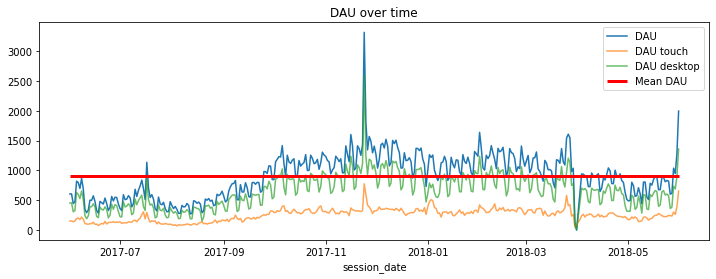

In [26]:
#DAU - calculation, printing results and plotting
dau = visits.groupby('session_date').agg({'uid':'nunique'}).reset_index()
dau_avg = visits.groupby('session_date').agg({'uid':'nunique'}).mean()
print('Average DAU: {}'.format(int(dau_avg)))

ax=dau.plot(x='session_date', figsize=(12,4), title='DAU over time')
visits.query('device=="touch"').groupby('session_date').agg({'uid': 'nunique'}).plot(alpha=0.7, ax=ax)
visits.query('device=="desktop"').groupby('session_date').agg({'uid': 'nunique'}).plot(alpha=0.7, ax=ax)
plt.hlines(dau_avg, visits['session_date'].min(), visits['session_date'].max(), colors=['red'], lw=3)
b= ax.legend(['DAU', 'DAU touch', 'DAU desktop', 'Mean DAU']);

In [27]:
#Now, we take a closer look at the peak and dip values. 
dau.max(), dau.min()

(session_date    2018-05-31
 uid                   3319
 dtype: object,
 session_date    2017-06-01
 uid                      1
 dtype: object)

In [28]:
#Here we find the exact dates by the user IDs found above in order to look for dip and spike reasons
dau[dau['uid']==3319], dau[dau['uid']==1]

(    session_date   uid
 176   2017-11-24  3319,
     session_date  uid
 303   2018-03-31    1)

In graph above we see visualization of the various DAUs in reference to the general mean across all DUA.
Looking at these metrics, overall we can see a shared trend among DAU, DAU touch, DAU desktop. The graphs have similar fluctuations. DAU desktop is around the mean, whereas DAU touch is much below mean. Meaning that DAU desktop are more popular for this service. 
All graph trends have a sharp peak in November 2017 and drop in March 2018. Peak can be explained given the season holidays, and March value close to zero, possibility indicating a technical issue causing site to be offline.

In [29]:
#This check is done to get a better understanding of the data
visits.source_id.value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

Check results show that 8 is missing, 6 and 7 are significantly low. This will be taken into consideration in further analysis.

In [30]:
#Here we are calculating DAU per source.
dau_sources = visits.groupby(['source_id', 
    'session_date']).agg({'uid':'nunique'}).reset_index().groupby('source_id').agg({'uid':'mean'}).reset_index()
dau_sources['percent'] = (dau_sources['uid'] / dau_sources['uid'].sum()) * 100
print('Average DAU per ad source:')
dau_sources

Average DAU per ad source:


source_id         uid    percent
0          1   80.557692   8.485028
1          2  120.707989  12.714001
2          3  232.865014  24.527342
3          4  275.454545  29.013237
4          5  175.622590  18.498079
5          6    1.000000   0.105329
6          7    1.058824   0.111524
7          9   36.110193   3.803435
8         10   26.033058   2.742025

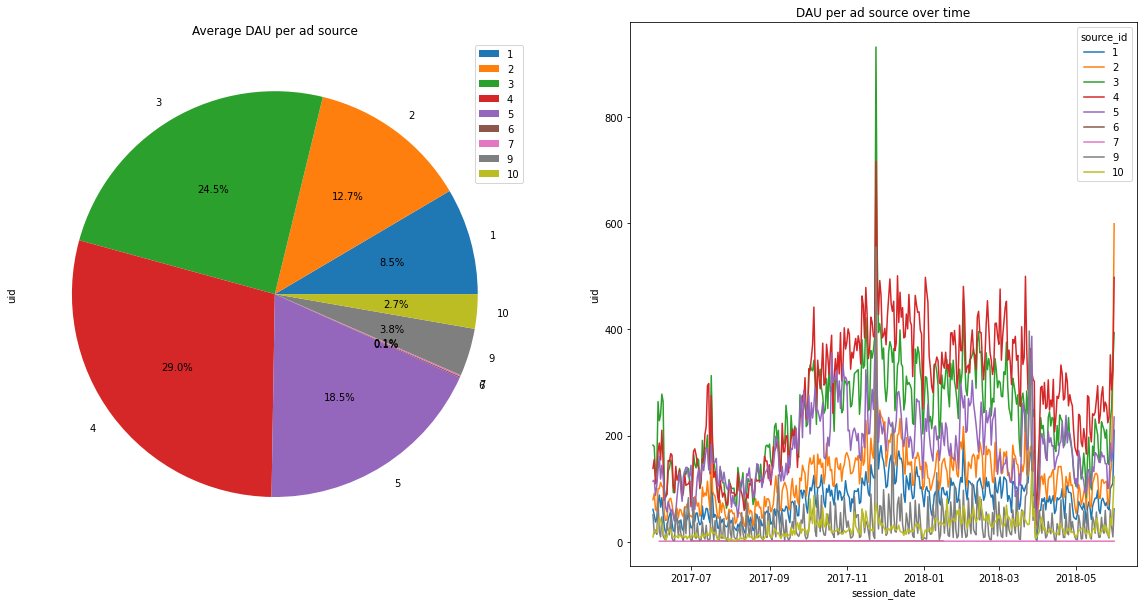

In [31]:
#Now, we visualize the results using plots 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

dau_sources.set_index('source_id').plot(y='uid', kind='pie', title = "Average DAU per ad source", 
                      autopct='%1.1f%%', ax=ax1)

plt.rcParams["figure.figsize"] = (20,4)
plt.title('DAU per ad source over time')
sns.lineplot(data=visits.groupby(['source_id', 'session_date'])['uid'].nunique().reset_index(), 
             x="session_date", y="uid", hue="source_id", palette='tab10',ax=ax2, legend='full')
plt.show()

Overall trends are alike, with few exceptions of source 6 and 7 as described below. 
The TOP 5 sources are:
- source 4 (red) except at the source 3 peak point around end of November 2017 (in green),
- source 3 (green),
- source 5 (purple),
- source 2 (orange),
- source 1 (dark blue).


Source 8 - non existing (as reported earlier).

Source 6 and 7 are lowest close to zero and close to each other (as we found above). 7 is visible but seems to override 6. In general, if we would zoom in by the hour maybe then we'd see their fluctuation trends.

Average WAU: 5724


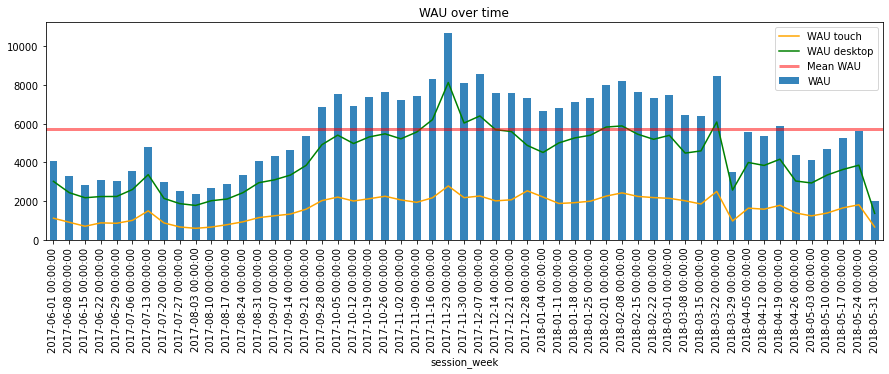

In [32]:
#Calculating, printing results and plotting WAU
wau = visits.groupby('session_week').agg({'uid':'nunique'}).reset_index()
wau_avg = visits.groupby('session_week').agg({'uid':'nunique'}).mean()
print('Average WAU: {}'.format(int(wau_avg)))

ax=wau.plot.bar(x='session_week', figsize=(15,4), title='WAU over time',alpha=0.9)
visits.query('device=="touch"').groupby('session_week').agg({'uid': 'nunique'}).plot(ax=ax, color='orange',use_index=False, mark_right=False)
visits.query('device=="desktop"').groupby('session_week').agg({'uid': 'nunique'}).plot(ax=ax, color='green',use_index=False, mark_right=False)
plt.hlines(wau_avg, xmin=-1, xmax=53, colors=['red'], lw=3, alpha=0.5)
plt.xticks(rotation=90)
b= ax.legend(['WAU touch', 'WAU desktop', 'Mean WAU','WAU']);

Above metrics show alike dynamic trends in WAUs. WAU touch is below avg like in DAU shown above.
WAU desktop is mostly below avg, yet between weeks 46-50 above avg.

In [33]:
#Here we are calculating WAU per source.
wau_sources = visits.groupby(['source_id', 
    'session_week']).agg({'uid':'nunique'}).reset_index().groupby('source_id').agg({'uid':'mean'}).reset_index()
wau_sources['percent'] = (wau_sources['uid'] / wau_sources['uid'].sum()) * 100
print('Average WAU per ad source:')
wau_sources

Average WAU per ad source:


source_id          uid    percent
0          1   464.698113   7.553001
1          2   716.358491  11.643379
2          3  1565.509434  25.445108
3          4  1830.622642  29.754143
4          5  1168.018868  18.984470
5          6     1.000000   0.016254
6          7     1.440000   0.023405
7          9   238.339623   3.873868
8         10   166.509434   2.706372

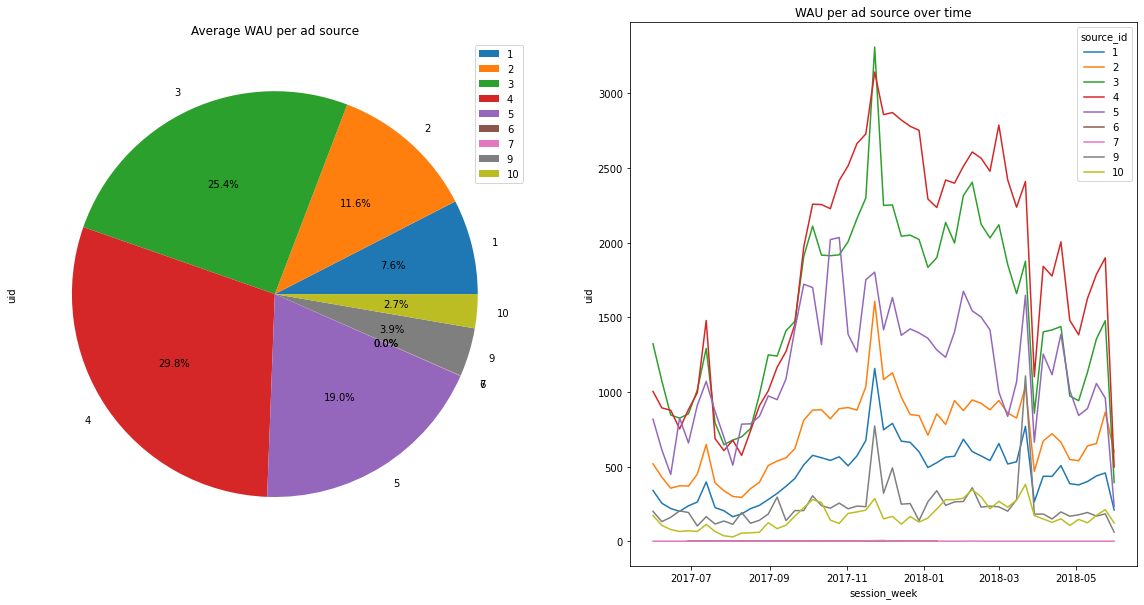

In [34]:
#Now, we visualize the results using plots 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

wau_sources.set_index('source_id').plot(y='uid', kind='pie', title = "Average WAU per ad source", 
                      autopct='%1.1f%%', ax=ax1)

plt.rcParams["figure.figsize"] = (20,4)
plt.title('WAU per ad source over time')
sns.lineplot(data=visits.groupby(['source_id', 'session_week'])['uid'].nunique().reset_index(), 
             x="session_week", y="uid", hue="source_id", palette='tab10',ax=ax2, legend='full')
plt.show()

Overall trends are alike, with few exceptions of source 6 and 7 as described below, and at the extremes of session_week scale.
The TOP 5 sources are:
- source 4 (red) except at the source 3 lead points around weeks 35-39 46 (in green) and source 5 lead point around weeks 33-34,
- source 3 (green),
- source 5 (purple),
- source 2 (orange),
- source 1 (dark blue).


Source 8 - non existing (as reported earlier).

Source 6 and 7 are lowest close to zero and close to each other (as we found above). 7 is visible but seems to override 6. In general, if we would zoom in by the hour maybe then we'd see their fluctuation trends.

Average MAU: 23228


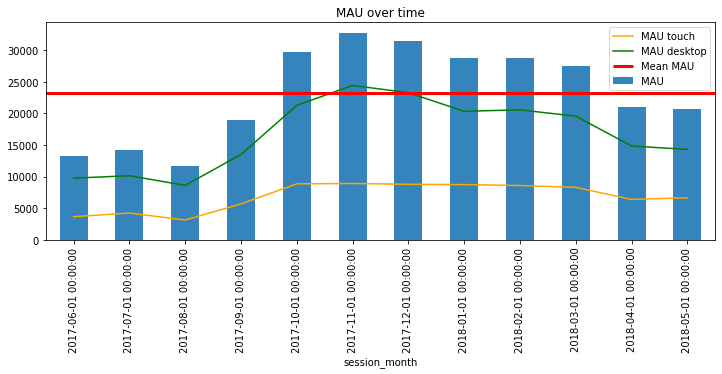

In [35]:
#Calculating, printing results and plotting MAU
mau = visits.groupby('session_month').agg({'uid':'nunique'}).reset_index()
mau_avg = visits.groupby('session_month').agg({'uid':'nunique'}).mean()
print('Average MAU: {}'.format(int(mau_avg)))

ax=mau.plot.bar(x='session_month', figsize=(12,4), title='MAU over time',alpha=0.9)
visits.query('device=="touch"').groupby('session_month').agg({'uid': 'nunique'}).plot(ax=ax, color='orange',use_index=False, mark_right=False)
visits.query('device=="desktop"').groupby('session_month').agg({'uid': 'nunique'}).plot(ax=ax, color='green',use_index=False,  mark_right=False)
plt.hlines(mau_avg, xmin=-1, xmax=12, colors=['red'], lw=3)
plt.xticks(rotation=90)
b= ax.legend(['MAU touch', 'MAU desktop', 'Mean MAU', 'MAU']);

Above metrics show alike dynamic trends in MAUs. MAU touch is below avg like in DAU and WAU shown above.
MAU desktop is mostly below avg, yet around month 11 above avg.

In [36]:
#Here we are calculating MAU per source.
mau_sources = visits.groupby(['source_id', 
    'session_month']).agg({'uid':'nunique'}).reset_index().groupby('source_id').agg({'uid':'mean'}).reset_index()
mau_sources['percent'] = (mau_sources['uid'] / mau_sources['uid'].sum()) * 100
print('Average MAU per ad source:')
mau_sources

Average MAU per ad source:


source_id          uid    percent
0          1  1818.750000   7.046392
1          2  2752.083333  10.662409
2          3  6758.833333  26.185779
3          4  7765.666667  30.086558
4          5  5017.916667  19.440938
5          6     1.000000   0.003874
6          7     2.833333   0.010977
7          9   987.000000   3.823939
8         10   707.000000   2.739133

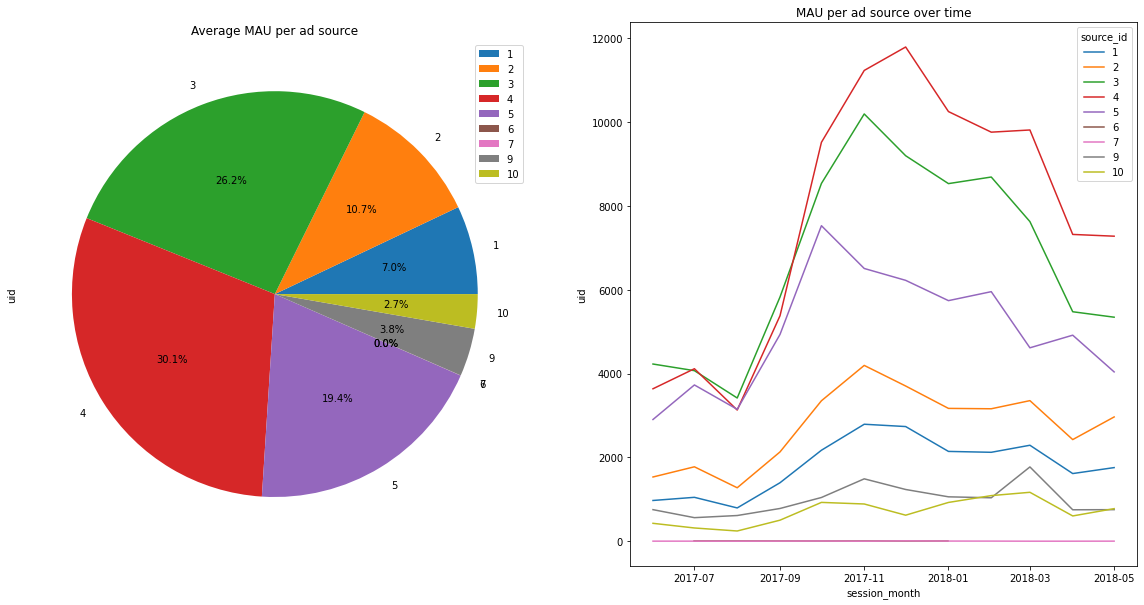

In [37]:
#Now, we visualize the results using plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

mau_sources.set_index('source_id').plot(y='uid', kind='pie', title = "Average MAU per ad source", 
                      autopct='%1.1f%%', ax=ax1, 
                              labeldistance=1.1)

plt.rcParams["figure.figsize"] = (20,4)
plt.title('MAU per ad source over time')
sns.lineplot(data=visits.groupby(['source_id', 'session_month'])['uid'].nunique().reset_index(), 
             x="session_month", y="uid", hue="source_id", palette='tab10',ax=ax2, legend='full')
plt.show()

Overall trends are alike, with few exceptions of source 6 and 7 as described below, and at the extremes of session_month scale.
The TOP 5 sources are:
- source 4 (red) except at the source 3 peak points around months 6-8 (in green),
- source 3 (green),
- source 5 (purple),
- source 2 (orange),
- source 1 (dark blue).


Source 8 - non existing (as reported earlier).

Source 6 and 7 are lowest close to zero and close to each other (as we found above). 7 is visible but seems to override 6. In general, if we would zoom in by the hour maybe then we'd see their fluctuation trends.

In [38]:
#Next, we check the sticky factors
sticky_factor_w = dau_avg/wau_avg*100
sticky_factor_m = dau_avg/mau_avg*100
print('DAU/WAU: {}'.format(sticky_factor_w))
print('DAU/MAU: {}'.format(sticky_factor_m))

DAU/WAU: uid    15.861739
dtype: float64
DAU/MAU: uid    3.90897
dtype: float64


Sticky factor per week 15.587 and per month 3.908

- 15% of weekly users use Yandex.Afisha on daily basis.
- 3% of monthly users use Yandex.Afisha on daily basis.

The monthly sticky factor (customers' loyalty) is low, while weekly is almost good (20% considered good, 25% exceptionally good).

### How many sessions are there per day? (One user might have more than one session.)

Average number of sessions per day: 987


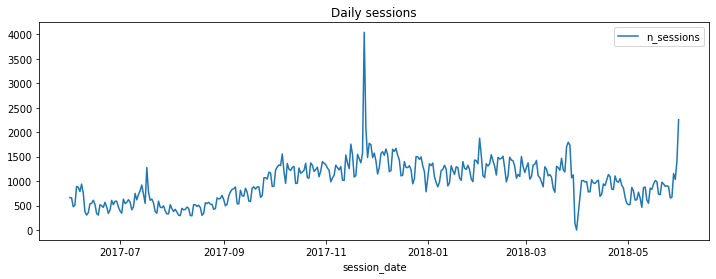

In [39]:
#Calculating the average number of sessions per day
sessions_per_day = visits.groupby(['session_date']).agg({'uid':'count'})
sessions_per_day  = sessions_per_day.rename(columns = {'uid':'n_sessions'})
print('Average number of sessions per day: {}'.format(int(sessions_per_day.mean())))
sessions_per_day.plot(figsize=(12,4),title='Daily sessions');

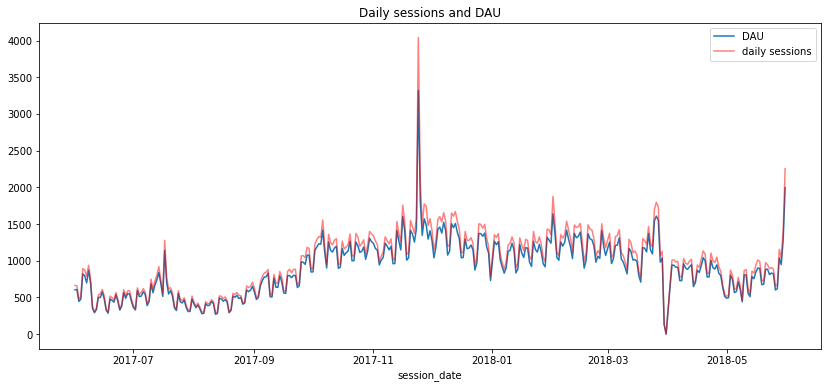

In [40]:
#Comparing dynamics of total number of sessions per day with the dynamics of DAU
ax=dau.plot(x='session_date', figsize=(14,6),title='Daily sessions and DAU');
sessions_per_day.plot(ax=ax, color='red',alpha=0.5)
ax.legend(["DAU", "daily sessions"]);

The daily number of sessions is slightly more than the DAU. Both trends are alike.

Daily number of sessions is slightly higher than DAU, meaning that users often use the service multiple times a day.

In [41]:
#Merging dau and session_per_day
dau = dau.merge(sessions_per_day, on = 'session_date')

Average number of sessions per user: 1.08


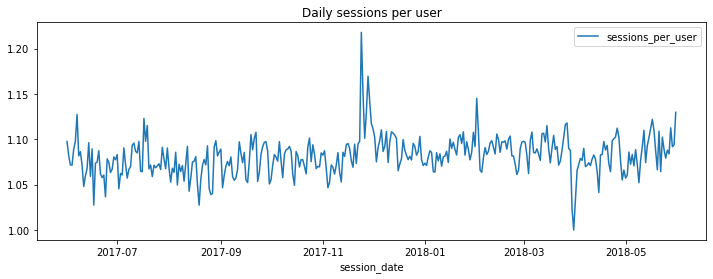

In [42]:
#Finding average number of daily sessions per user
dau['sessions_per_user'] = dau['n_sessions']/dau['uid']
dau.plot(x='session_date',y='sessions_per_user', figsize=(12,4), title='Daily sessions per user')
print('Average number of sessions per user: {}'.format(round(dau['sessions_per_user'].mean(),2)));

The entire observation period indicates that daily number of sessions per user varies from 1 to over 1.2, meaning that people mostly use the service more than once a day.

Average sessions per user per day:
touch	1.051071574166503,
desktop	1.088955311524761


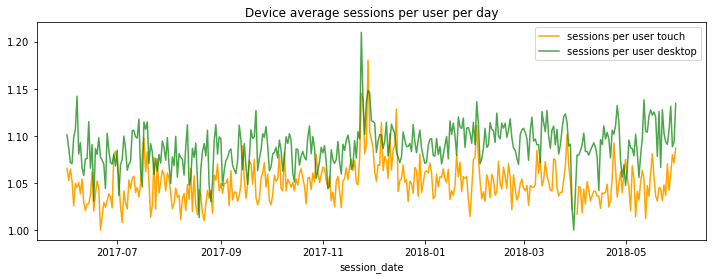

In [43]:
#Splitting user session distribution by device to find leading platform
sessions_per_user = visits.groupby(['session_date','device']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']

sess_touch = sessions_per_user.reset_index().query('device=="touch"')['sessions_per_user'].mean()
sess_desktop = sessions_per_user.reset_index().query('device=="desktop"')['sessions_per_user'].mean()
print("Average sessions per user per day:\ntouch\t{},\ndesktop\t{}".format(sess_touch, sess_desktop))

ax1=sessions_per_user.reset_index().query('device=="touch"').plot(x='session_date',y='sessions_per_user', figsize=(12,4), color='orange',title='Device average sessions per user per day')
sessions_per_user.reset_index().query('device=="desktop"').plot(x='session_date',y='sessions_per_user',alpha=0.7, ax=ax1, color='green')
ax1.legend(["sessions per user touch", "sessions per user desktop"]);

Above, graph depicts similar tendencies for both session devices touch and desktop. Desktop is higher by 0.03 on avg. Peaks and dips are consistent.   

In [44]:
#Finding daily sessions per source
sessions_per_day_sources = visits.groupby(['source_id','session_date']).agg({'uid':'count'})
sessions_per_day_sources = sessions_per_day_sources.groupby('source_id').agg({'uid':'mean'}).astype('int').reset_index()
sessions_per_day_sources['percent'] = (sessions_per_day_sources['uid'] / sessions_per_day_sources['uid'].sum()) * 100
print('Average sessions per day per ad source:')
sessions_per_day_sources

Average sessions per day per ad source:


source_id  uid    percent
0          1   93   9.412955
1          2  131  13.259109
2          3  235  23.785425
3          4  280  28.340081
4          5  184  18.623482
5          6    1   0.101215
6          7    1   0.101215
7          9   36   3.643725
8         10   27   2.732794

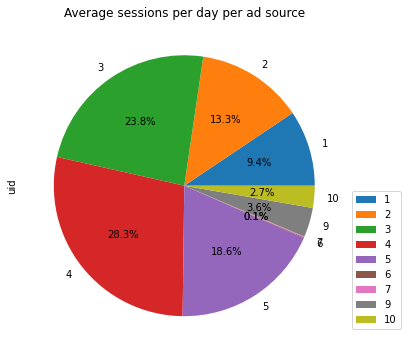

In [45]:
(sessions_per_day_sources.set_index('source_id')
                .plot(y='uid', kind='pie', 
                      title = "Average sessions per day per ad source", 
                      figsize=(6, 6), autopct='%1.1f%%', wedgeprops={'linewidth': 0}))
plt.legend(bbox_to_anchor=(1.0, 0.5));

Ad sources 1-5 are in the lead with a total of 93.4% of sessions.
TOP 5 ad sources: 
- source 4 (red), 
- source 3 (green),
- source 5 (purple), 
- source 2 (orange), 
- source 1 (dark blue).

(6 and 7 are close to zero and close to each other, therefore not properly displayed. Ad source 8 doesn't exist in df) 

### What is the length of each session?

In [46]:
#Finding the length between Start Ts and End Ts for each session(row) 
visits['session_len'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid session_week session_month  session_year session_date  \
0  16879256277535980062   2017-12-14    2017-12-01          2017   2017-12-20   
1    104060357244891740   2018-02-15    2018-02-01          2018   2018-02-19   
2   7459035603376831527   2017-06-29    2017-07-01          2017   2017-07-01   
3  16174680259334210214   2018-05-17    2018-05-01          2018   2018-05-20   
4   9969694820036681168   2017-12-21    2017-12-01          2017   2017-12-27   

   session_len  
0         1080  
1         1680  
2            0  
3         1440  
4            0

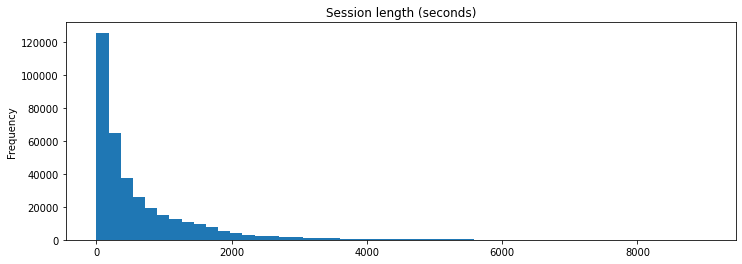

In [47]:
#Plotting session length results
visits['session_len'].plot(figsize=(12,4),title='Session length (seconds)',kind='hist',bins=50,range=(0,9000));

Session length results indicate a right skewed histogram.

In [48]:
#Calculating the average difference using mode since the histogram is positively skewed
asl=visits['session_len'].mode()
print('Average session length:', int(asl), 'seconds')

Average session length: 60 seconds


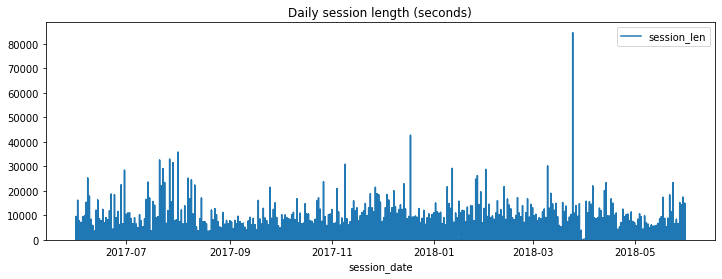

In [49]:
#Plotting daily seesions
visits.plot(x='session_date',y='session_len',title='Daily session length (seconds)', ylim=(0), figsize=(12,4));

Graph depicts sessions with 0 duration possibly indicating connection error or system downtime for maintenance. Whereas high durations could possibly mean that devices were left open on site regardless of any action. 
Trends remain alike throughout the analysis of the dataset.

In [50]:
#Splitting session length distribution by device to find leading platform
len_devices = visits.groupby('device')['session_len'].agg(lambda x:x.mode())
print('Average session length per device:')
len_devices

Average session length per device:


device
desktop    60
touch      60
Name: session_len, dtype: int64

Average of both devices is 60 sec, same as general average.

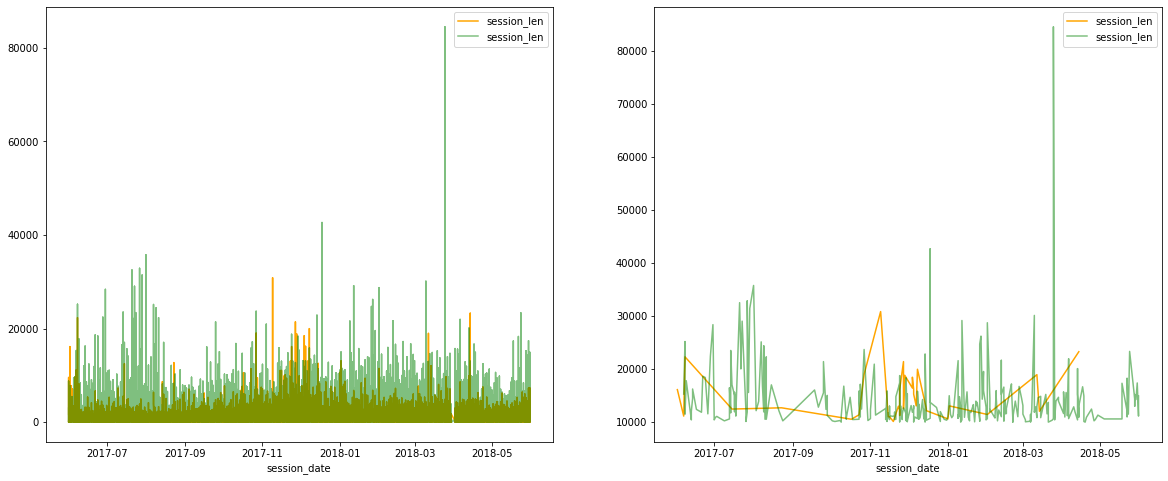

In [51]:
#Now plotting daily session length per device for further analysis
#and another plot over 10,000 sec for readability
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

visits.reset_index().query('device=="touch"').plot(x='session_date',y='session_len', color='orange',ax=ax1)
visits.reset_index().query('device=="desktop"').plot(x='session_date',y='session_len',ax=ax1,alpha=0.5, color='green')
ax.legend(["session length touch", "session length desktop"]);

visits.loc[visits["session_len"] > 10000].reset_index().query('device=="touch"').plot(x='session_date',y='session_len', color='orange',ax=ax2)
visits.loc[visits["session_len"] > 10000].reset_index().query('device=="desktop"').plot(x='session_date',y='session_len',ax=ax2,alpha=0.5, color='green')
ax.legend(["session length touch", "session length desktop"]);

Graphs show an unproportional peak for desktop use (March 2018). This could be explained for a user leaving or forgetting site open. Zero values due to errors as stated above, i.e., technical and connectivity issues.
Desktop values mostly lead over touch, with few exception as can be seen in yellow higher than green values. This can be explained for users leaving site open on desktop absentmindedly.

### How often do users come back?

In [52]:
#Calculating the retention rate based on cohorts
#Start by finding first visit date per user
first_visit_date = visits.groupby(['uid'])['start_ts'].min().reset_index()
first_visit_date.columns = ['uid', 'first_visit']
visits = visits.merge(first_visit_date.set_index('uid'), on='uid', how='left')

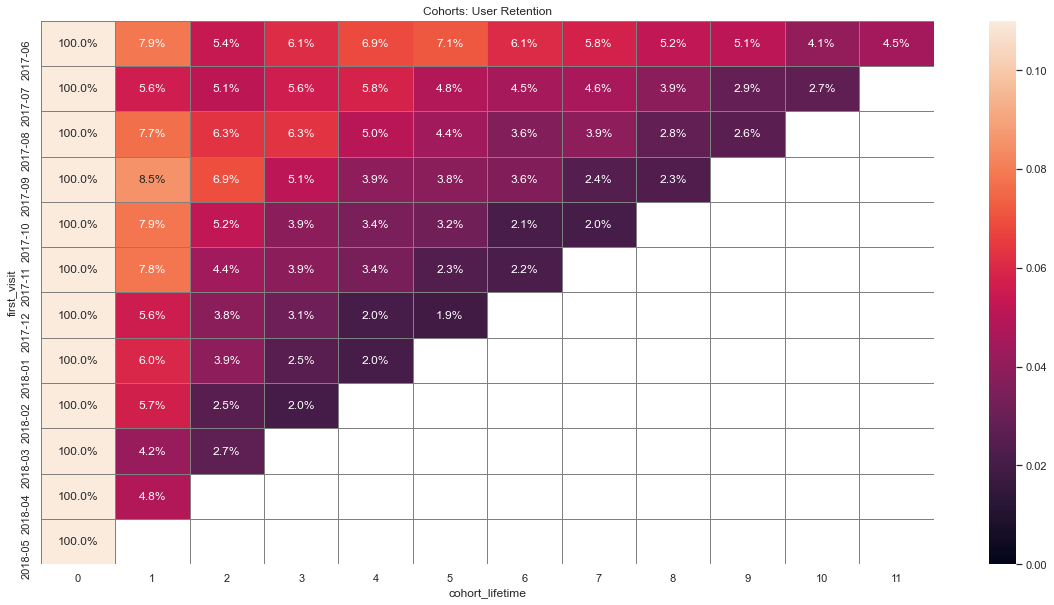

In [53]:
#Calculating month for first visit and rest 
visits['first_visit'] = visits['first_visit'].astype('datetime64[M]')
visits['session_date'] = visits['session_date'].astype('datetime64[M]')
#Calculating lifetime months
visits['cohort_lifetime'] = ((pd.to_datetime(visits['session_date']) - pd.to_datetime(visits['first_visit']))
                            /np.timedelta64(1,'M')).round().astype('int')
#Building first visit month cohorts  
cohorts = visits.groupby(['first_visit', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
#Calculating initial users per cohort
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid': 'cohort_uid'})
#Adding initial users count to DF
cohorts = cohorts.merge(initial_users_count, on='first_visit')
#Calculating retention
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_uid']
cohorts['first_visit'] = cohorts['first_visit'].dt.strftime('%Y-%m')
#Building pivot table
retention_pivot = cohorts.pivot_table(index='first_visit', columns='cohort_lifetime', values='retention', aggfunc='sum')

#Creating and printing heatmap
sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0,vmax=0.11);

Retention indicates how many registered users were active on a certain day/week/month after registration/first visit. Retention is a % of those registered who returned. In general, retention rates decline over time. It is a common understanding that it is easier to retain customers than attract new ones. 

Graph depicts cohorts lifetime and retention calculations on a monthly basis. 
We compiled a pivot table retention_pivot and created a heatmap to visualize the info more clearly.
First_visit is 0 on cohort_lifetime axis, per each month age is calculated.
The age answers the question: "How long after registration passed till user made action?"

Highest retention rate is in September 2017.

Overall, retention rate drops as age increases for all months.
The cohort of 2017-09 has the highest retention on 1st month (8.5%).
The two 2nd highest months are 2017-06 and 2017-10 (7.9%).

Given no more than 8.5% of users simultaneously re-access service from previous months, and every month the number of users decreases, most spent investments are on attracting new clients.
Given after the first experience, most do not contact site again. 
It is essential to figure out the reasons why users were unhappy and mitigate them. 
Following this we should calculate how many users have re-contacted the site, i.e., connected more than 1 time.

## Sales

### When do people start buying?

In [54]:
#Finding first visit and first order dates per user
first_visit = visits.groupby('uid')['start_ts'].min()
first_visit.name = 'first_visit'

first_order = orders.groupby('uid')['buy_ts'].min()
first_order.name = 'first_order'

#Joining first visit and first order
first_visit = first_visit.reset_index()
first_order = first_order.reset_index()
first_visit_order = pd.merge(left=first_visit,right=first_order, on ='uid').reset_index()

In [55]:
#Finding difference in days between first visit and first order
first_visit_order['conversion'] = first_visit_order['first_order'] - first_visit_order['first_visit']
first_visit_order['conversion'] = first_visit_order['conversion']/np.timedelta64(1,'D')

#Dropping duplicates and missing values - if any (users that didn't convert)
first_visit_order.drop_duplicates(inplace=True,keep='first')
first_visit_order.reset_index(drop=True, inplace=True)
first_visit_order.dropna()

index                   uid         first_visit         first_order  \
0          0       313578113262317 2017-09-18 22:49:00 2018-01-03 21:51:00   
1          1      1575281904278712 2017-06-03 10:13:00 2017-06-03 10:13:00   
2          2      2429014661409475 2017-10-11 17:14:00 2017-10-11 18:33:00   
3          3      2464366381792757 2018-01-27 20:10:00 2018-01-28 15:54:00   
4          4      2551852515556206 2017-11-24 10:14:00 2017-11-24 10:14:00   
...      ...                   ...                 ...                 ...   
36518  36518  18445147675727495770 2017-08-20 13:30:00 2017-11-24 09:03:00   
36519  36519  18445407535914413204 2017-09-22 23:48:00 2017-09-22 23:55:00   
36520  36520  18445601152732270159 2017-08-07 11:51:00 2018-03-26 22:54:00   
36521  36521  18446156210226471712 2017-11-07 10:01:00 2018-02-18 19:34:00   
36522  36522  18446167067214817906 2017-10-17 10:05:00 2017-10-17 10:16:00   

       conversion  
0      106.959722  
1        0.000000  
2        0.054861  
3        0.822222  
4        0.000000  
...           ...  
36518   95.814583  
36519    0.004861  
36520  231.460417  
36521  103.397917  
36522    0.007639  

[36523 rows x 5 columns]

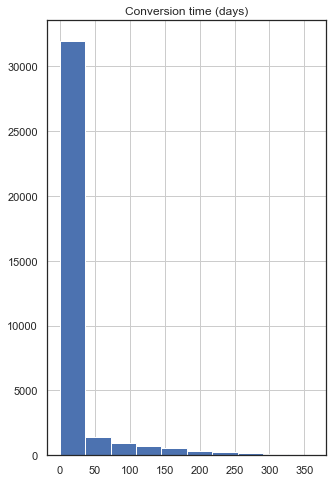

In [56]:
#Plotting distribution of difference between first visit and first order in days
first_visit_order['conversion'].hist(figsize=(5,8))
plt.title('Conversion time (days)');

Most users made purchases on the day of registration. So we see a high conversion on 0d.
This makes sense with typical online stores, usually people register with an intent to purchase. Following a significant dip.

In [57]:
#Finding conversion description
first_visit_order.groupby('uid')['conversion'].min().describe()

count    36523.000000
mean        16.902900
std         47.072760
min          0.000000
25%          0.002778
50%          0.011111
75%          2.011806
max        363.294444
Name: conversion, dtype: float64

Conversion description of the 36,523 users has an average of 16.9 days. With min being 0 as in same day conversion and max almost a year apart at 363~. 

In [58]:
print('Overall conversion is {:.1%}'.format(orders['uid'].nunique()/visits['uid'].nunique()))

Overall conversion is 16.0%


Overall conversion of 16%, above 10% is considered good. 

In [59]:
visits.groupby('uid').agg({'source_id':'nunique'}).sort_values(by = 'source_id',ascending = False).head()

source_id
uid                            
7060677486475916423           7
9019681082555518724           7
14481163132396345939          7
2445395077403109224           7
1242922364974949363           7

In [60]:
#One user can have even 7 different sources. We take recent source.
last_date_s = visits.groupby('uid').agg({'start_ts':'max'}).reset_index()

#We subset to delete duplicated user IDs
source = pd.merge(visits[['uid','source_id']].drop_duplicates(subset=['uid']),last_date_s, on = 'uid')

#Now, we merge first_visit_order and source tables.
source_merge = first_visit_order.merge(source[['uid','source_id']], on = 'uid')

#Sources of users who placed an order.
conversion_source = source_merge[source_merge['conversion'] >= 0]

In [61]:
#Calculating conversion by source.
conversion_by_source = conversion_source.groupby('source_id').agg({'conversion':['mean','count']}).reset_index()
conversion_by_source.columns = ['source_id','mean','count']
conversion_by_source['ratio_count'] = (conversion_by_source['count'] / conversion_by_source['count'].sum()*100)
conversion_by_source = conversion_by_source[conversion_by_source['mean'] != 0].reset_index()
conversion_by_source

index  source_id       mean  count  ratio_count
0      0          1  14.705157   3743    10.248337
1      1          2  21.902650   4323    11.836377
2      2          3  16.212197   9138    25.019851
3      3          4  16.814720   9823    26.895381
4      4          5  13.322743   6839    18.725187
5      5          7   0.036111      1     0.002738
6      6          9  32.413564   1415     3.874271
7      7         10  13.956916   1241     3.397859

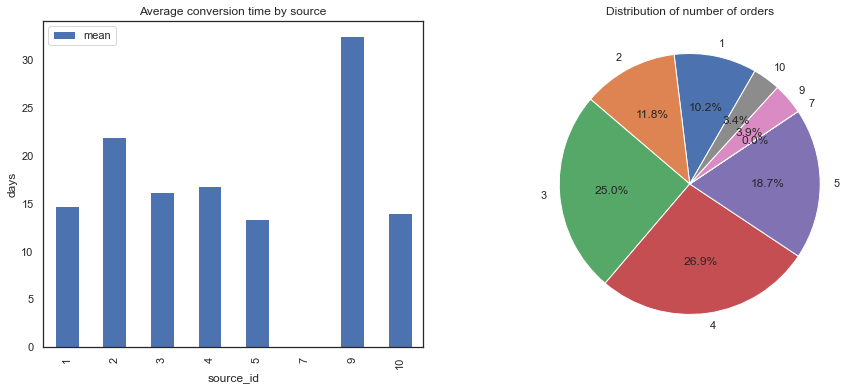

In [62]:
#Plotting
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1 = plt.subplot(121)
plt.xlabel('source')
plt.ylabel('days')
plt.title('Average conversion time by source')
conversion_by_source.plot.bar(x='source_id',y='mean', ax=ax1)

ax2 = plt.subplot(122).pie(conversion_by_source['ratio_count'],labels=conversion_by_source['source_id'],
        autopct = '%1.1f%%',startangle = 60)
plt.title('Distribution of number of orders')

plt.show()

Bars depict there are no orders from sources 6 and 8, and 7 is the lowest, i.e., the best at 0.03 with only one user. 
The longest conversion is for source 9, with  only 2.9% of orders. 
Excluding source 7, the shortest is for source 5, closely followed by 10, 1, 3, 4 and then 2. 
The most popular sources are 4 and 3, jointly accounting for 51.9% 

In [63]:
#Now same for device
visits.groupby('uid').agg({'device':'nunique'}).sort_values(by = 'device',ascending = False).head()

device
uid                         
10695240366599660152       2
1724693760721641828        2
9887864976816243302        2
17902667191250257068       2
15202288659943748638       2

In [64]:
#One user can have 2 devices. Looking at recent device.
last_date_d = visits.groupby('uid').agg({'start_ts':'max'}).reset_index()

#We subset to delete only duplicated user IDs
device = pd.merge(visits[['uid','device']].drop_duplicates(subset=['uid']),last_date_d, on = 'uid')

#Merge first_visit_order and device tables.
device_merge = first_visit_order.merge(device[['uid','device']], on = 'uid')

#Device of users who placed an order.
conversion_device = device_merge[device_merge['conversion'] >= 0]

In [65]:
#Conversion distribution by device
conversion_by_device = conversion_device.groupby('device').agg({'conversion':['mean','count']}).reset_index()
conversion_by_device.columns = ['device','mean','count']
conversion_by_device['ratio_count'] = (conversion_by_device['count'] / conversion_by_device['count'].sum()*100)
conversion_by_device

device       mean  count  ratio_count
0  desktop  16.339945  29222    80.009857
1    touch  19.156108   7301    19.990143

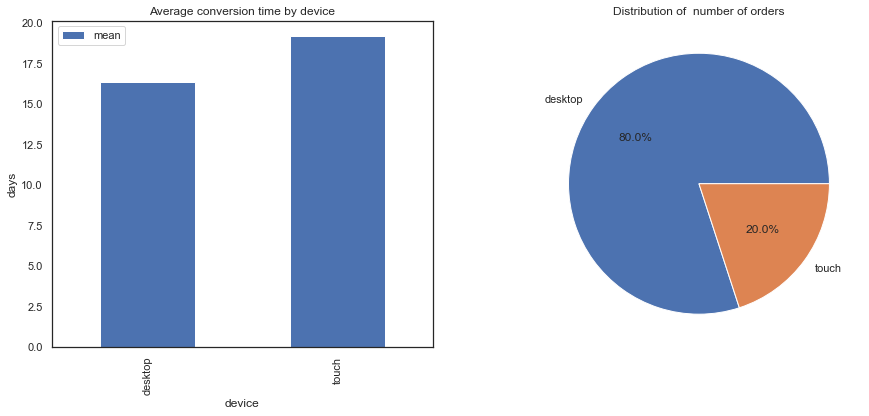

In [66]:
#Plotting
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1 = plt.subplot(121)
conversion_by_device.plot.bar(x='device',y='mean', ax=ax1)

plt.xlabel('device')
plt.ylabel('days')
plt.title('Average conversion time by device')
   
ax2 = plt.subplot(122)
ax2.pie(conversion_by_device['ratio_count'],
        labels  = conversion_by_device['device'],
        autopct = '%1.1f%%')
plt.title('Distribution of  number of orders')

plt.show()

Pie chart illustrates 80% of orders come from desktop devices. Average order conversion time for desktop is shorter than touch, approx. 2.5 days. 

### How many orders do they make during a given period of time?

In [67]:
#Adding column for month
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders = orders.merge(first_order.set_index('uid'), on='uid', how='left')

In [68]:
#Cohort month by first purchase
orders['first_order_month']=orders['first_order'].astype('datetime64[M]')
orders.head()

buy_ts  revenue                   uid order_month  \
0 2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01   
1 2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01   
2 2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01   
3 2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01   
4 2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01   

          first_order first_order_month  
0 2017-06-01 00:10:00        2017-06-01  
1 2017-06-01 00:25:00        2017-06-01  
2 2017-06-01 00:27:00        2017-06-01  
3 2017-06-01 00:29:00        2017-06-01  
4 2017-06-01 07:58:00        2017-06-01

In [69]:
#Cohort size by month of first purchase
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns=['first_order_month','cohort_size']
cohort_sizes.head()

first_order_month  cohort_size
0        2017-06-01         2023
1        2017-07-01         1923
2        2017-08-01         1370
3        2017-09-01         2581
4        2017-10-01         4340

In [70]:
#Calculating number of purchases for cohort and month
cohort=orders.groupby(['first_order_month','order_month'])['revenue'].count().reset_index()
cohort.columns=['first_order_month','order_month','orders']

#Merge cohort month with cohort size
cohort=cohort.merge(cohort_sizes,on=['first_order_month'])
cohort['age_month'] = ((cohort['order_month'] - cohort['first_order_month']) / np.timedelta64(1,'M')).round()
cohort['orders_per_buyer']=cohort['orders']/cohort['cohort_size']
cohort.head()

first_order_month order_month  orders  cohort_size  age_month  \
0        2017-06-01  2017-06-01    2354         2023        0.0   
1        2017-06-01  2017-07-01     177         2023        1.0   
2        2017-06-01  2017-08-01     174         2023        2.0   
3        2017-06-01  2017-09-01     226         2023        3.0   
4        2017-06-01  2017-10-01     292         2023        4.0   

   orders_per_buyer  
0          1.163618  
1          0.087494  
2          0.086011  
3          0.111715  
4          0.144340

In [71]:
#Creating pivot table
cohort_pivot=cohort.pivot_table(
    index='first_order_month', 
    columns='age_month', 
    values='orders_per_buyer', 
    aggfunc='sum'
).cumsum(axis=1)

cohort_pivot.round(2).fillna('')

age_month          0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
first_order_month                                                               
2017-06-01         1.16  1.25  1.34  1.45  1.59   1.7  1.84  1.92  2.03   2.1   
2017-07-01         1.14  1.19  1.25  1.31  1.34  1.39  1.42  1.44  1.47  1.49   
2017-08-01         1.12   1.2  1.27  1.33  1.39  1.44  1.47  1.53  1.56   1.6   
2017-09-01         1.14  1.22  1.28  1.35  1.37  1.42  1.46  1.48   1.5         
2017-10-01         1.14  1.22  1.25  1.28  1.31  1.34  1.35  1.38               
2017-11-01         1.18  1.28  1.32  1.37  1.41  1.42  1.45                     
2017-12-01         1.15  1.21  1.26   1.3  1.32  1.34                           
2018-01-01         1.12  1.19  1.24  1.25  1.28                                 
2018-02-01         1.12  1.18  1.21  1.22                                       
2018-03-01         1.17  1.22  1.27                                             
2018-04-01         1.10  1.18                                                   
2018-05-01         1.09                                                         
2018-06-01         1.00                                                         

age_month          10.0  11.0  
first_order_month              
2017-06-01         2.15  2.19  
2017-07-01         1.51        
2017-08-01                     
2017-09-01                     
2017-10-01                     
2017-11-01                     
2017-12-01                     
2018-01-01                     
2018-02-01                     
2018-03-01                     
2018-04-01                     
2018-05-01                     
2018-06-01

Orders per buyer are all between 1 (June 2018- age month 0) to 2.19 (June 2017- age month 11) their first order month being a year apart. Only in age month of 8-11 with first order being in June 2017 do buyers make two orders. 
As age month progresses number of orders grows by at least 0.01 (except May 2018 which is missing age month 1). June 2018 has lowest first month orders (1), November 2017 has highest (1.18). 

### What is the average purchase size?

In [72]:
#Adding order_id column as an unique identifier for each row 
orders['order_id']=orders['uid']+orders['buy_ts'].astype('int')
orders.head(3)

buy_ts  revenue                   uid order_month  \
0 2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01   
1 2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01   
2 2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01   

          first_order first_order_month      order_id  
0 2017-06-01 00:10:00        2017-06-01  1.182558e+19  
1 2017-06-01 00:25:00        2017-06-01  1.312353e+19  
2 2017-06-01 00:27:00        2017-06-01  1.939996e+19

In [73]:
#Calculating avg check and plotting 
avg_check=orders.groupby(['order_id'])['revenue'].sum().reset_index()
fig = px.histogram(avg_check, x="revenue")
fig.show()

In [74]:
#Cohort analysis on averge revenue:
avg_cohort=orders.groupby(['first_order_month','order_month'])['revenue'].apply(lambda x: x.mode()).reset_index()
avg_cohort['age_month'] = ((avg_cohort['order_month'] - avg_cohort['first_order_month']) / np.timedelta64(1,'M')).round()
avg_cohort.head()


avg_cohort_piv=avg_cohort.pivot_table(
    index='first_order_month', 
    columns='age_month', 
    values='revenue', 
    aggfunc='mean')

avg_cohort_piv.round(2).fillna('')

age_month          0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   \
first_order_month                                                         
2017-06-01         3.67  2.44  1.52  1.83  2.65  1.83  3.05  4.89  3.05   
2017-07-01         4.89  9.78  9.78  3.05  0.92  1.83  2.75  8.56  3.67   
2017-08-01         1.83  2.44  3.67  4.07  3.67  3.67  1.47  2.44  6.11   
2017-09-01         1.83  1.83  1.83   5.5  1.42  1.83  4.89  7.33  1.47   
2017-10-01         1.22  3.67  1.83  1.83  4.89  2.44  0.49  0.61         
2017-11-01         2.44  2.44  2.13  3.67  1.22  1.22  0.37               
2017-12-01         3.67  1.83  2.44  2.44  1.52  3.05                     
2018-01-01         1.83  1.22  3.67  4.28  1.83                           
2018-02-01         1.83  1.83  2.65  1.83                                 
2018-03-01         2.44  1.83  1.83                                       
2018-04-01         2.44  3.05                                             
2018-05-01         3.67                                                   
2018-06-01         3.42                                                   

age_month           9.0   10.0  11.0  
first_order_month                     
2017-06-01          1.22  1.22  0.61  
2017-07-01         27.42  2.44        
2017-08-01          3.67              
2017-09-01                            
2017-10-01                            
2017-11-01                            
2017-12-01                            
2018-01-01                            
2018-02-01                            
2018-03-01                            
2018-04-01                            
2018-05-01                            
2018-06-01

Highest revenue is 27.42 for buyers with first order month 2017-07 with age month 9 (the rest are all 9.78 and under- almost 2/3 less). Lowest is 0.37 for first order month 2017-11 with age month 6. 

Highest revenue for age month 0 is 4.89 for first order month 2017-07. Lowest is 1.22 for first order month 2017-10.  

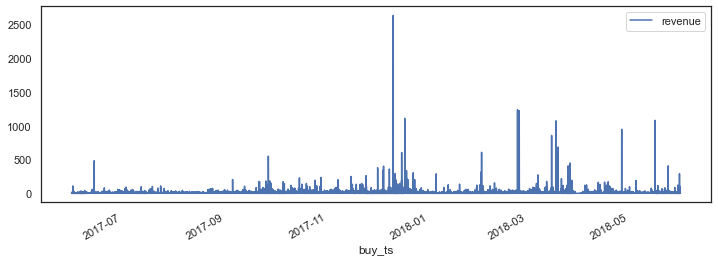

In [75]:
#Genral plotting of revenue to determine what method we should use for finding avg
orders.plot(x='buy_ts', y='revenue',figsize=(12,4));

In [76]:
#Finding average purchase size and describing revenue column
print('Average purchase size:', round(orders['revenue'].mean(),2)) 
orders['revenue'].describe()

Average purchase size: 5.0


count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

Average purchase size is ~5. 

Min is 0, meaning error or visit without order. 

Max is 2633.28, possibly one order by a buyer for multiple people.

In [77]:
#Sorting avg monthly revenue by device
user_devices = visits[['uid', 'device']]
user_devices = user_devices.drop_duplicates(subset='uid')

orders = orders.merge(user_devices, on='uid')

revenue_devices = orders.pivot_table(index=['order_month'], 
                                         columns='device', values='revenue', aggfunc='mean', margins=True).round(2)

revenue_devices

device               desktop  touch   All
order_month                              
2017-06-01 00:00:00     4.17   3.52  4.06
2017-07-01 00:00:00     5.30   5.35  5.31
2017-08-01 00:00:00     4.89   4.63  4.85
2017-09-01 00:00:00     5.69   4.16  5.42
2017-10-01 00:00:00     4.98   4.70  4.93
2017-11-01 00:00:00     4.66   5.32  4.78
2017-12-01 00:00:00     6.42   3.33  5.85
2018-01-01 00:00:00     4.26   3.50  4.11
2018-02-01 00:00:00     5.19   3.46  4.84
2018-03-01 00:00:00     5.56   4.82  5.41
2018-04-01 00:00:00     5.25   4.67  5.15
2018-05-01 00:00:00     4.91   4.17  4.77
2018-06-01 00:00:00     3.42    NaN  3.42
All                     5.17   4.26  5.00

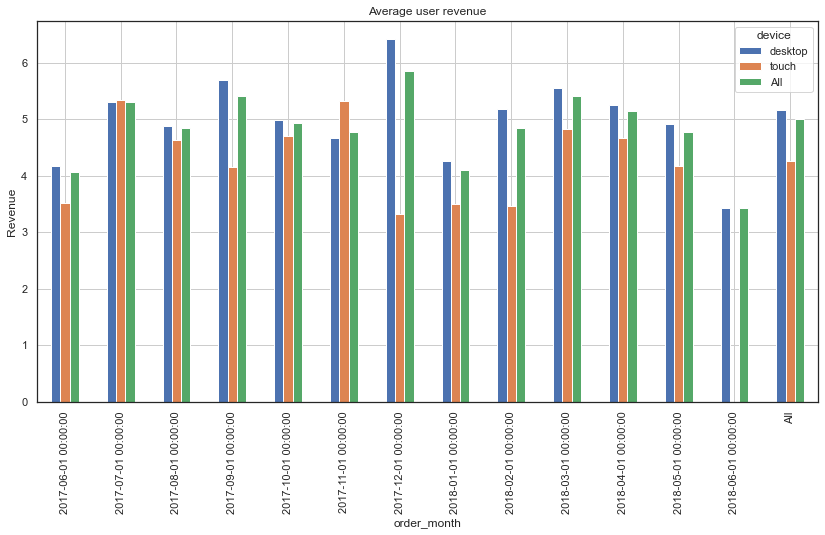

In [78]:
#Visualizing
ax = revenue_devices.plot(kind="bar", figsize=(14,7), grid=True , title='Average user revenue')
ax.set_ylabel('Revenue')
plt.show()

Graph above reveals that:
- No touch orders during 2018-06. 

- Best month for touch is 2017-07, and for desktop is 2017-12.

- Lowest avg revenue for touch is month 2017-12 (excluding 2018-06), and for desktop is 2018-06.

- Desktop mostly leads over touch except for 2017-07 and 2017-11.

- In general the highest monthly avg revenue in total is during 2017-12, and lowest is during 2018-06 (possibly given the relatively low sales for desktop and the nonexistent ones for touch).

In [79]:
#Now sorting avg monthly revenue by source
user_sources = visits[['uid', 'source_id']]
user_sources = user_sources.drop_duplicates(subset='uid')

orders = orders.merge(user_sources, on='uid')

#Creating pivot table
revenue_sources = orders.pivot_table(index=['order_month'], 
                                         columns='source_id', values='revenue', aggfunc='mean', margins=True).round(2)

revenue_sources

source_id               1      2     3     4     5     7     9    10   All
order_month                                                               
2017-06-01 00:00:00  4.38   4.47  3.97  4.34  4.14   NaN  2.97  1.95  4.06
2017-07-01 00:00:00  6.51   5.89  4.89  5.60  4.60   NaN  4.57  3.16  5.31
2017-08-01 00:00:00  5.05   5.38  5.11  4.41  4.90  1.22  4.10  4.02  4.85
2017-09-01 00:00:00  7.29   7.53  4.67  4.79  4.70   NaN  3.81  2.16  5.42
2017-10-01 00:00:00  5.63   8.11  3.99  4.07  4.79   NaN  3.88  2.45  4.93
2017-11-01 00:00:00  5.76   6.34  4.22  4.50  4.21   NaN  3.49  3.69  4.78
2017-12-01 00:00:00  4.71  14.67  4.00  3.84  4.69   NaN  3.18  3.22  5.85
2018-01-01 00:00:00  5.26   5.81  3.72  3.46  3.78   NaN  2.70  2.89  4.11
2018-02-01 00:00:00  4.84   9.69  3.72  4.10  3.97   NaN  3.27  2.40  4.84
2018-03-01 00:00:00  6.98  10.51  4.06  4.32  4.37   NaN  2.61  2.78  5.41
2018-04-01 00:00:00  7.52   7.44  3.76  4.81  4.06   NaN  5.11  2.47  5.15
2018-05-01 00:00:00  5.54   6.99  3.70  4.64  3.82   NaN  3.78  3.58  4.77
2018-06-01 00:00:00   NaN    NaN   NaN  3.42   NaN   NaN   NaN   NaN  3.42
All                  5.77   8.42  4.05  4.29  4.33  1.22  3.45  2.83  5.00

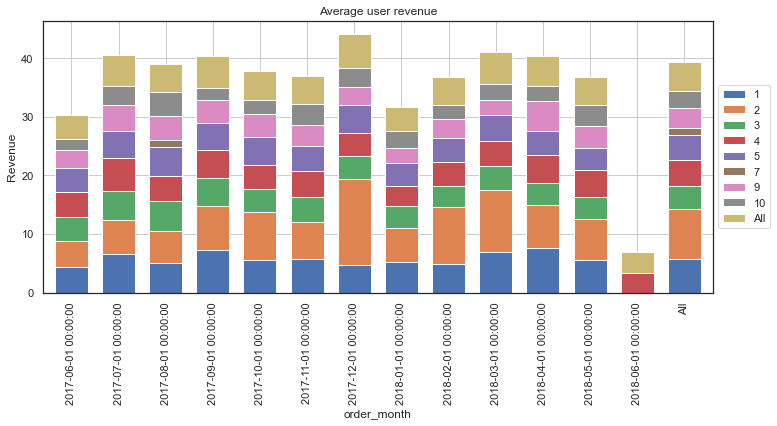

In [80]:
#Visualizing
ax = revenue_sources.plot(kind="bar", figsize=(12,5), grid=True,width=0.7,stacked=True, title='Average user revenue')
ax.set_ylabel('Revenue')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Graph above shows:
- Source 8 doesn't exist, source 6 doesn't generate revenue at all here.

- Source 7 is used during 2017-08 only.

- In 2018-06, only source 4 is generates revenue.

- Source 2 is mostly in the lead.

- Source 10 is mostly least used (excluding source 7).

- In general, the highest monthly avg revenue in total is 5.85 during 2017-12, and lowest is 3.42 during 2018-06 (possibly given the use of two sources only).

### How much money do they bring? (LTV)

In [81]:
#Keeping margin rate=1, so gross profit=revenue
#Calculating monthly revenue per cohort
ltv_cohort=orders.groupby(['first_order_month','order_month'])['revenue'].sum().reset_index()
ltv_cohort.columns = ['first_order_month','month','revenue']

In [82]:
#Merging with cohort size
ltv_cohort=ltv_cohort.merge(cohort_sizes,on=['first_order_month'])

In [83]:
#Adding age and LTV columns
ltv_cohort['age']=((ltv_cohort['month'] - ltv_cohort['first_order_month']) / np.timedelta64(1,'M')).round()
ltv_cohort['ltv']=ltv_cohort['revenue']/ltv_cohort['cohort_size']
ltv_cohort.head()

first_order_month      month  revenue  cohort_size  age       ltv
0        2017-06-01 2017-06-01  9557.49         2023  0.0  4.724414
1        2017-06-01 2017-07-01   981.82         2023  1.0  0.485329
2        2017-06-01 2017-08-01   885.34         2023  2.0  0.437637
3        2017-06-01 2017-09-01  1931.30         2023  3.0  0.954671
4        2017-06-01 2017-10-01  2068.58         2023  4.0  1.022531

In [84]:
#LTV is a cumulative metric, so we use cumsum() when creating pivot table
ltv_cohort_piv=ltv_cohort.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='sum'
).cumsum(axis=1)

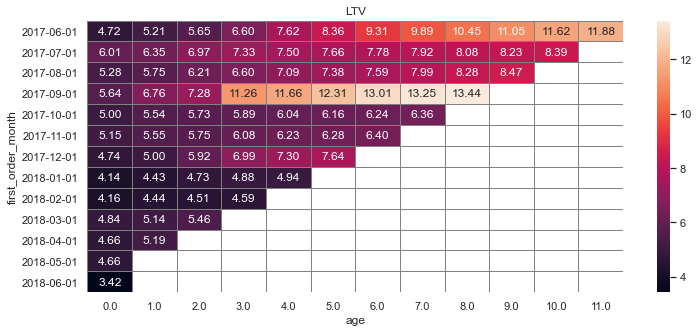

In [85]:
#Plotting heatmap
ltv_cohort_piv.index=ltv_cohort_piv.index.astype(str)
plt.figure(figsize=(12,5))
sns.heatmap(ltv_cohort_piv,annot=True,fmt='.2f',linewidths=1,linecolor='grey').set(title='LTV')
plt.show()

We see:
- As age per month progresses, LTV grows.

- Highest LTV for age 0 is 6.01 when first order month is 2017-07, and lowest is 3.42 when first order month is 2018-06.

- Highest LTV is 13.44 for age 8 when first order month is 2017-09, and lowest is 3.42 for age 0 when first order month is 2018-06.

- 2017-09 has the best progressive trend over its period of time, with LTV age 4 equal to age 3 multiplied by ~1.546, and has the best cumulative LTV after six months as well.

In [86]:
#Calculating avg LTV after various periods of time
print('Average LTV for 3 months from the first order:', ltv_cohort_piv.cumsum(axis=1).mean(axis=0)[2])
print('Average LTV for 6 months from the first order:', ltv_cohort_piv.cumsum(axis=1).mean(axis=0)[5])
print('Average LTV for 9 months from the first order:', ltv_cohort_piv.cumsum(axis=1).mean(axis=0)[8])

Average LTV for 3 months from the first order: 16.206494395373753
Average LTV for 6 months from the first order: 40.028463579000075
Average LTV for 9 months from the first order: 72.54781754080247


The trend is growing just like in our LTV heatmap above.

## Marketing

### How much money was spent? Overall/per source/over time

In [87]:
#Sorting costs for futher analysis and finding overall marketing cost
costs=costs.sort_values(by=['dt','source_id'])

print('Overall marketing cost: {}'.format(costs['costs'].sum()))

Overall marketing cost: 329131.62


In [88]:
#Calculating daily costs
costs_daily = costs.groupby('dt').agg({'costs':'sum'})

#Calculating monthly costs
costs['month']=costs['dt'].astype('datetime64[M]')
costs_monthly = costs.groupby('month').agg({'costs':'sum'})

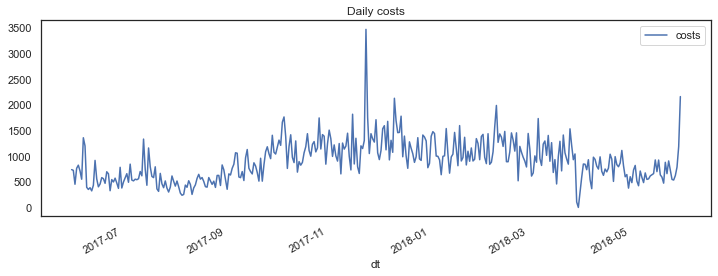

In [89]:
#Plotting daily costs
costs_daily.plot(figsize=(12,4), title='Daily costs');

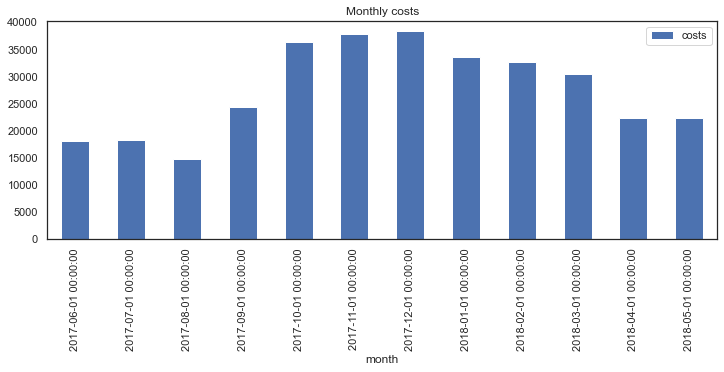

In [90]:
#Plotting montly costs
costs_monthly.plot.bar(figsize=(12,4), title='Monthly costs');

In [91]:
#Find date of max cost
costs_daily[costs_daily['costs']==costs_daily['costs'].max()]

costs
dt                 
2017-11-24  3458.86

In [92]:
#Find date of min cost
costs_daily[costs_daily['costs']==costs_daily['costs'].min()]

costs
dt               
2018-03-31    0.7

Graph above is similar to the number of visits per day. Obviously, this isn't surprising, since marketing costs directly influence number of visits. 

The max daily sharp increase in costs on 2017-11-24, explains the previously presented spikes in number of orders, visits, and income over the same period.

The min daily costs on 2018-03-31, explains the previously presented dips in number of orders, visits, and income over the same period.

As for revenue, trend is similar, yet shifted by about a month, which makes sense. Only after spending on marketing costs, results show an increase in revenue.

In [93]:
#Plotting daily costs over time
fig = px.histogram(costs, x="month", y="costs", color='source_id')
fig.update_layout(bargap=0.2)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

Graph above indicates similar trends. Source 3 costs are higher than other sources. Both sources 9 and 10 are the cheapest (near 0).

The costs are the highest towards the holiday season and new year (October to January).

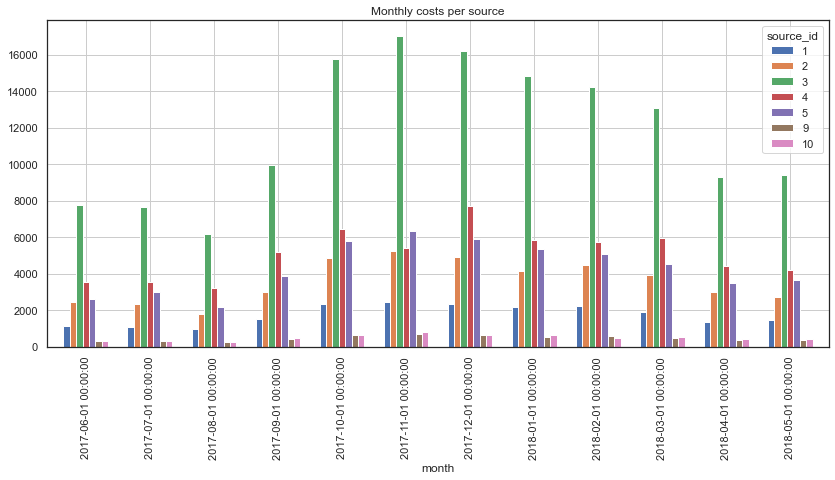

In [94]:
#Pivot table and plotting 
costs.pivot_table(index='month',columns='source_id',values='costs',
                  aggfunc='sum').plot(kind="bar", figsize=(14,6),grid=True, width=0.7,title='Monthly costs per source');

In [95]:
#Next, we check how costs are split across sources
costs_per_source=costs.groupby(['source_id'])['costs'].sum().reset_index()
costs_per_source

source_id      costs
0          1   20833.27
1          2   42806.04
2          3  141321.63
3          4   61073.60
4          5   51757.10
5          9    5517.49
6         10    5822.49

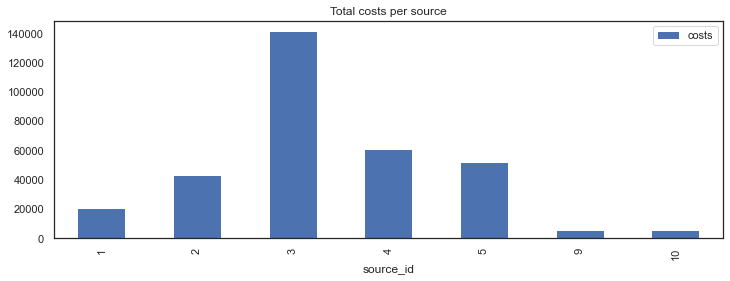

In [96]:
costs_per_source.plot(x='source_id',kind='bar', title='Total costs per source',figsize=(12,4));

In graphs above, data is clearly depicted.
As seen, the largest costs are for Source 3, more than double of Source 4.
Sources 3 and 4 provided close number of orders (as calculated earlier). Hence, it might make sense to reallocate advertising budget more evenly between them.

### How much did customer acquisition from each of the sources cost?

In [97]:
#Calculate monthly costs
monthly_costs=costs.groupby(['month'])['costs'].sum().reset_index()
monthly_costs.head()

month     costs
0 2017-06-01  18015.00
1 2017-07-01  18240.59
2 2017-08-01  14790.54
3 2017-09-01  24368.91
4 2017-10-01  36322.88

In [98]:
#Calculate monthly buyers
monthly_buyers=orders.groupby(['first_order_month'])['uid'].nunique().reset_index()
monthly_buyers.columns=['month','buyers']
monthly_buyers.head()

month  buyers
0 2017-06-01    2023
1 2017-07-01    1923
2 2017-08-01    1370
3 2017-09-01    2581
4 2017-10-01    4340

In [99]:
#Calculate customer acqusition costs (cac)
monthly_CAC=monthly_costs.merge(monthly_buyers,how='left',on=['month'])
monthly_CAC['CAC']=monthly_CAC['costs']/monthly_CAC['buyers']
monthly_CAC.head()

month     costs  buyers        CAC
0 2017-06-01  18015.00    2023   8.905091
1 2017-07-01  18240.59    1923   9.485486
2 2017-08-01  14790.54    1370  10.796015
3 2017-09-01  24368.91    2581   9.441654
4 2017-10-01  36322.88    4340   8.369327

In [100]:
#Plot monthly cac calculations
fig = px.line(monthly_CAC, x="month", y="CAC",title='Monthly CAC')
fig.show()

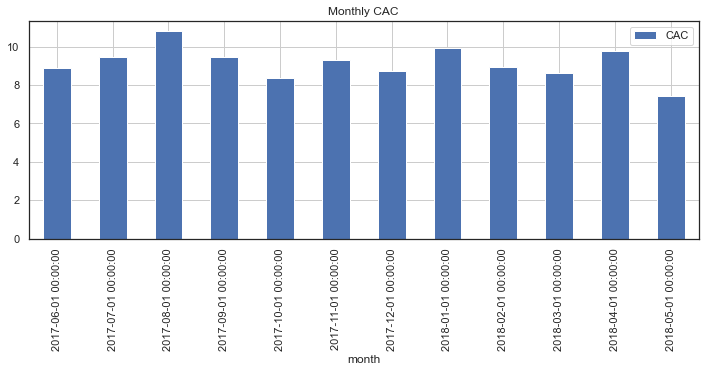

In [101]:
monthly_CAC.plot(kind='bar',x="month", y="CAC", title='Monthly CAC', figsize=(12,4), grid=True);

In [102]:
print('Average CAC:', round(monthly_CAC['CAC'].mean(),2)) 

Average CAC: 9.15


The average CAC over time is 9.15.

Monthly CAC trends fluctuate slightly between 7 to 11, indicating no apparent correlations with revenue nor DAU.
DAU has a negative correlation with CAC. It can be explained, that when there are fewer  visits and lower revenues, then more money is spent to attract more customers. 

During May and New Year holiday season, CAC is relatively lower because during holidays people buy online regardless of marketing efforts in general.

In [103]:
#Calculating CAC per source
#Need to find source of users
#Look at visits table, even if user didn't purchase, he still came from a given source 
visits.groupby(['uid'])['source_id'].nunique().head()

uid
11863502262781     1
49537067089222     1
297729379853735    1
313578113262317    1
325320750514679    1
Name: source_id, dtype: int64

In [104]:
#Some users come accross more than one source
#Find first source and consider as origin source.
first_source=visits.sort_values('session_date').groupby('uid').first()['source_id'].reset_index()
first_source.columns=['uid','first_source']
first_source.head()

uid  first_source
0   11863502262781             3
1   49537067089222             2
2  297729379853735             3
3  313578113262317             2
4  325320750514679             5

In [105]:
#Data found above is merged with orders
orders=orders.merge(first_source[['uid','first_source']],on=['uid'],how='left')
first_source=orders[['first_source','uid','first_order','first_order_month']]
first_source.head()

first_source                   uid         first_order first_order_month
0             1  10329302124590727494 2017-06-01 00:10:00        2017-06-01
1             2  11627257723692907447 2017-06-01 00:25:00        2017-06-01
2             2  17903680561304213844 2017-06-01 00:27:00        2017-06-01
3             2  16109239769442553005 2017-06-01 00:29:00        2017-06-01
4             3  14200605875248379450 2017-06-01 07:58:00        2017-06-01

In [106]:
#Check how CAC changes over time for each source
source_costs=costs.groupby(['dt','source_id'])['costs'].sum().reset_index()
source_costs.head()

dt  source_id   costs
0 2017-06-01          1   75.20
1 2017-06-01          2  132.56
2 2017-06-01          3  349.38
3 2017-06-01          4   76.74
4 2017-06-01          5   73.24

In [107]:
#Find buyers per source
first_source['first_order']=first_source['first_order'].astype('datetime64[D]')
buyers_per_source=first_source.groupby(['first_order','first_source'])['uid'].nunique().reset_index()
buyers_per_source.columns=['dt','source_id','buyers']
buyers_per_source.head()

dt  source_id  buyers
0 2017-06-01          1      14
1 2017-06-01          2      16
2 2017-06-01          3      30
3 2017-06-01          4       8
4 2017-06-01          5      12

In [108]:
#Calculate CAC
CAC_per_source=source_costs.merge(buyers_per_source,on =['source_id','dt'])#,left_on =['source_id','dt'], right_on=['source_id', 'dt'])
CAC_per_source['CAC']=CAC_per_source['costs']/CAC_per_source['buyers']
CAC_per_source['month']=CAC_per_source['dt'].astype('datetime64[M]')
CAC_per_source.head()

dt  source_id   costs  buyers        CAC      month
0 2017-06-01          1   75.20      14   5.371429 2017-06-01
1 2017-06-01          2  132.56      16   8.285000 2017-06-01
2 2017-06-01          3  349.38      30  11.646000 2017-06-01
3 2017-06-01          4   76.74       8   9.592500 2017-06-01
4 2017-06-01          5   73.24      12   6.103333 2017-06-01

In [109]:
#Plotting CAC per source
fig = px.histogram(CAC_per_source, x="month", y="CAC",color='source_id',title='CAC per source')
fig.update_layout(bargap=0.2)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

In [110]:
avg_cac_per_source = CAC_per_source.groupby('source_id')['CAC'].agg(lambda x:x.mean())
print('Average CAC per source:')
avg_cac_per_source

Average CAC per source:


source_id
1      7.227239
2     14.038239
3     16.930642
4      7.712634
5      8.160371
9      7.026384
10     6.651669
Name: CAC, dtype: float64

Graph above depicts the overall CAC trend. 

Source 3 is the most expensive, with the highest avg. Source 10 has the lowest cac on list.

Source 8 doesn't exist, as mentioned earlier. 

Sources 6 and 7 probably have zero values and therefore not included here, this makes sense since they bring insignificant visitors (6 and 36 respectively, in comparison to others bringing in approx. 10K-101K). 

All sources listed share a common trend with the exception of source 4. 

### How worthwhile where the investments? (ROI)

In genereal, ROI=LTV/CAC

We calculated CAC per month and have found info on LTV in ltv_cohort. 

In [111]:
#Starting with ROI per cohort
CAC_per_month_ROI=monthly_CAC[['month','CAC']]
CAC_per_month_ROI.columns=['first_order_month','CAC']
ROI=ltv_cohort.merge(CAC_per_month_ROI,on=['first_order_month'],how='left')
ROI.head()

first_order_month      month  revenue  cohort_size  age       ltv       CAC
0        2017-06-01 2017-06-01  9557.49         2023  0.0  4.724414  8.905091
1        2017-06-01 2017-07-01   981.82         2023  1.0  0.485329  8.905091
2        2017-06-01 2017-08-01   885.34         2023  2.0  0.437637  8.905091
3        2017-06-01 2017-09-01  1931.30         2023  3.0  0.954671  8.905091
4        2017-06-01 2017-10-01  2068.58         2023  4.0  1.022531  8.905091

In [112]:
#Adding return on investment (ROI) column
ROI['ROI']=ROI['ltv']/ROI['CAC']
roi_piv = ROI.pivot_table(
    index='first_order_month', columns='age', values='ROI', aggfunc='mean').cumsum(axis=1).round(2)

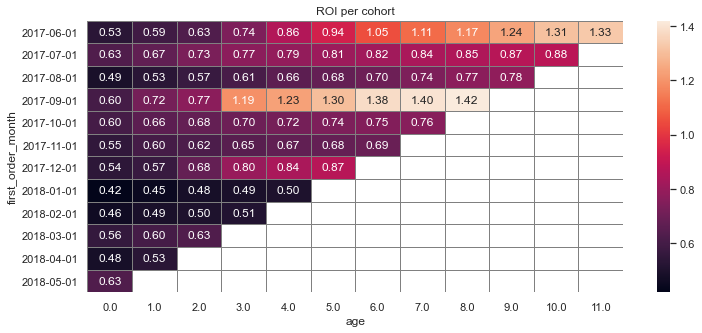

In [113]:
#Plotting heatmap
roi_piv.index=roi_piv.index.astype(str)
plt.figure(figsize=(12,5))
sns.heatmap(roi_piv,annot=True,fmt='.2f',linewidths=1,linecolor='grey').set(title='ROI per cohort')
plt.show()

The highest ROI is 1.42 for 2017-09 age 8, lowest is 0.42 for 2018-01 age 0.

ROI values grow as age progresses.

We only have a break-even ROI when values reach 1, occurring as of age 3 of 2017-09 and age 6 of 2017-06.

Calculating ROI is a good indication whether investment is efficient and/or making business profitable. In our case, only two cohorts paid off. 

In [114]:
#Calculating and plotting ROI per source 
ltv_per_source=orders.groupby(['first_source'])['uid','revenue'].agg({'uid':'nunique','revenue':'sum'}).reset_index()
ltv_per_source.columns=['source_id','buyers','revenue']
ltv_per_source['ltv']=ltv_per_source['revenue']/ltv_per_source['buyers']
ltv_per_source

roi_per_source=costs_per_source.merge(ltv_per_source,on=['source_id'])
roi_per_source['cac']=roi_per_source['costs']/roi_per_source['buyers']
roi_per_source['romi']=roi_per_source['ltv']/roi_per_source['cac']
roi_per_source

fig = px.bar(roi_per_source, x='source_id', y='romi', title='ROMI per source')
fig.update_xaxes(type='category')
fig.show()

Graph above can be summarized as follows:

Source 1 has best ROI followed by source 2, both have ROI over 1.

Sources 5 and 9 just break-even.

Sources 6 and 7 are not included here given their near to 0 values.

Source 8 is non existent.

Source 3 has the least ROI, yet the highest CAC as shown above and hence we would recommend cutting it out or finding new marketing strategies for it.

Source 1 has low costs, short convergence time, good ROI, yet not leading DAU and sessions and hence we would recommend to increase its marketing budget flow.

In [115]:
#Calculating LTV for each source id
cohort_sizes_source = orders.groupby(['first_order_month', 'source_id']).agg({'uid': 'nunique'}).reset_index()
cohort_sizes_source.columns = ['first_order_month','source_id','buyers']

#Creating cohorts
cohort_source = orders.groupby(['first_order_month','order_month', 'source_id']).agg({'revenue':'sum','uid':'nunique'})
cohort_source = cohort_source.reset_index()
cohort_source['age'] = ((cohort_source['order_month'] - cohort_source['first_order_month'])/ np.timedelta64(1,'M')).round()

#LTV dataframe
ltv_source = pd.merge(cohort_sizes_source, cohort_source, on=['first_order_month','source_id'])
ltv_source['ltv'] = ltv_source['revenue'] / ltv_source['buyers']

#Finding monthly costs per source
monthly_costs_source = costs.groupby(['month','source_id'])['costs'].sum()
monthly_costs_source.index.set_names(['first_order_month','source_id'],inplace=True)

#Creating ROMI dataframe and calculating it
ROMI = pd.merge(ltv_source, monthly_costs_source, left_on=['first_order_month','source_id'], right_on=['first_order_month','source_id'])

ROMI['cac'] = ROMI['costs'] / ROMI['buyers']
ROMI['romi'] = ROMI['ltv'] / ROMI['cac']

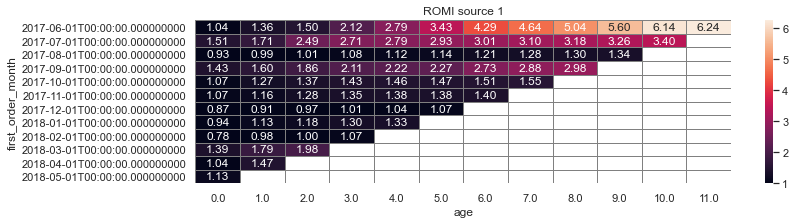

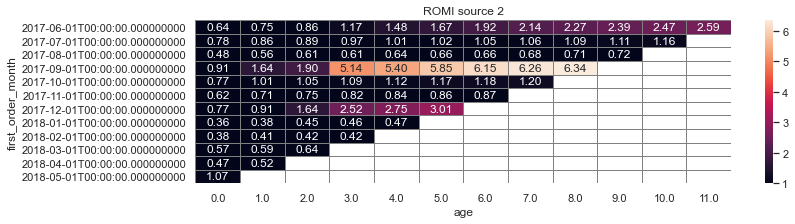

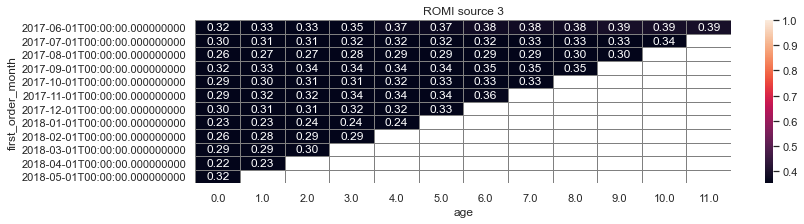

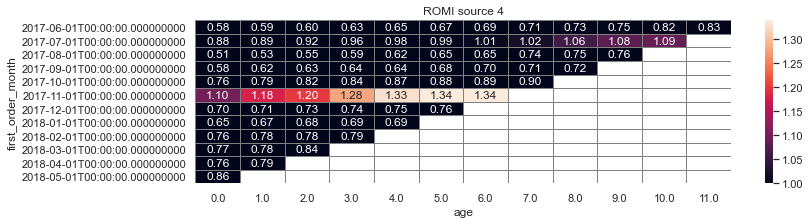

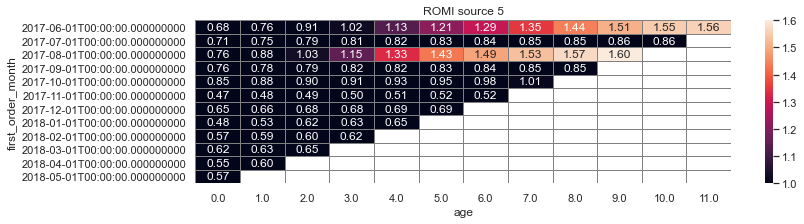

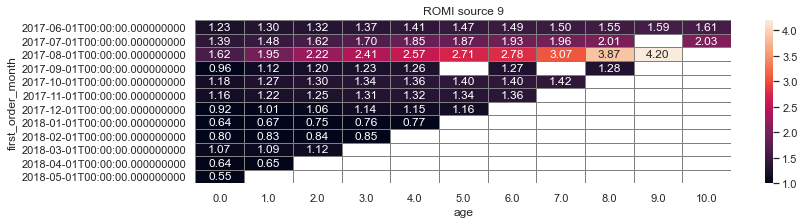

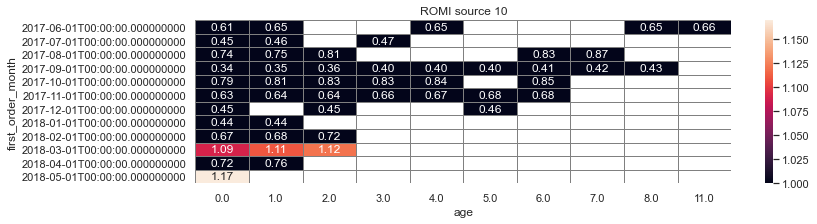

In [116]:
#Plotting ROMI heatmaps for each source
sources=ROMI['source_id'].unique()
i=0
for source in sources:
    romi_piv = ROMI.query("source_id==@source").pivot_table(
    index='first_order_month', 
    columns='age', 
    values='romi', 
    aggfunc='mean').cumsum(axis=1).round(2)
    plt.figure(figsize=(12, 3))
    sns.heatmap(romi_piv, annot=True, fmt='.2f', linewidths=1, linecolor='gray',vmin=1)
    plt.title("ROMI source " + str(source))
    i = i+1
    plt.show();

Graphs above can be summarized as follows:
- Source 1 is the most profitable source, totally paid off by age month 3, and eventually gets to 6.24 by age 11, followed by source 2 paying off by age 10 and getting to 5.14 by age 3 of 2017-09.

- Source 3 marketing investments have the lowest ROMI all below 1, followed by 10 that only gets to 1 in all ages of 2018-03. 

- Sources 6 and 7 have no ROMI at all and 8 doesn't exist.

# General conclusion

In summary, this project provides actionable insights to the marketing experts on how much money to invest and where.

In this project, we followed the methodology as follows:
- Open the date file and study the general information.
- Data preprocessing including verifying there are no missing values and converting data to required types.
- Make calculations and add necessary columns as required for the analysis.
- Plot graphs for metrics and then interpret the results.
- And now, final conclusion.

Our findings:
- DAU: 907, WAU: 5825, MAU: 23,228.
- Source 4 leads in DAU/WAU/MAU, source 6 comes in last.
- Sticky factors, weekly: 15.587, monthly: 3.908.
- Average number of daily sessions: 987.
- Average number of daily sessions per user: 1.08.
- Average number of daily sessions per device, touch: 1.05, desktop: 1.08.
- Source 3 leads in average number of daily sessions, sources 6 and 7 come in last.
- Average session length: 60 seconds.
- Average session length per device, touch: 60, desktop: 60.
- Retention is normal.
- Conversion description of the 36,523 users has an average of 16.9 days. With min being 0 as in same day conversion and max almost a year apart at 363~.
- Overall conversion is 16%, 10% is considered good.
- Source 4 leads in number of orders, sources 6 and 7 come in last with zero orders.
- Source 5 leads in conversion time, source 9 comes in last.
- Number of orders per device, touch: 20%, desktop: 80%.
- Conversion time per device, touch takes longer than desktop.
- Orders per buyer are 1-2.19.
- Average purchase size (revenue): 4.999.
- Highest revenue: 27.42 and lowest: 0.37.
- Average revenue per device, touch: 4.26, desktop: 5.17.
- Source 2 leads in average user revenue, source 7 comes in last.
- LTV shows us positive dynamics.
- Average LTV, 3 months: 16.206, 6 months: 40.028, 9 months: 72.547.
- Overall marketing cost: 329,131.62.
- Source 3 leads in total costs (highest), sources 9 and 10 come in last (6 and 7 are 0).
- Average CAC: 9.15.
- Source 3 leads in average CAC (highest), source 10 comes in last (6 and 7 are 0).
- The highest ROI is 1.42 for 2017-09 age 8, lowest is 0.42 for 2018-01 age 0.
- Only break-even ROI occurring as of age 3 of 2017-09 and age 6 of 2017-06 (only two cohorts paid off).
- Source 1 leads in ROMI, source 3 comes in last (6 and 7 are 0).

Our recommendations:
- We recommend the **desktop** platform.

- As for sources, we recommend **source 1**, given its overall fast conversion rate and highest ROI. On the other hand, we recommend to cut out **source 3** given its metrics as described above.

- In general, new strategic marketing plans should be implemented to promote **appropriation** of their services and online platform.

- Engage **touch** users, who have access to service at the tips of their fingers always.

- Retention rate can be improved by **loyalty** programs, such as bring a friend bonus program, returning customer benefits, VIP clubs.

- Improve **proactive and viral** mailing lists and engaging newsletters.

- Engage **social media influencers**.

- Consider **targeted ads**, as a new generating revenue source and customer engagement.